In [2]:
import os, sys
import math
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
from typing import Optional, List, Tuple, Dict, Union
from dataclasses import dataclass, field

script_dir = os.path.dirname(os.path.abspath(__file__)) if "__file__" in locals() else os.getcwd()
for i in range(1, 5): # Check up to 4 levels up
    dir_up = os.path.abspath(os.path.join(script_dir, *(['..'] * i)))
    if dir_up not in sys.path:
        sys.path.append(dir_up)
    sys.path.append(os.path.join(dir_up, "QES", "general_python"))

try:
    import jax
    import jax.numpy as jnp
    import gymnasium as gym
    # for Flax
    import optax
    import flax.linen as nn
    from flax.training.train_state import TrainState
    from flax.linen.initializers import orthogonal
except ImportError as e:
    print("Please install the required packages: jax, jaxlib, gymnasium, optax, flax")
    sys.exit(1)
    
# common utilities for logging
try:
    from QES.general_python.common.flog import Logger, get_global_logger
    from QES.general_python.common.directories import Directories
    from QES.general_python.common.plot import Plotter
    from QES.Algebra.hamil_quadratic import QuadraticSelection
    from QES.general_python.physics.entropy_jax import vn_entropy_jax
    from QES.general_python.physics.density_matrix_jax import rho_jax, schmidt_jax
    from QES.general_python.physics.entropy import EntropyPredictions
except ImportError as e:
    print(f"Error importing custom modules (QES, extractors): {e}")
    print("Please ensure these modules are in the Python path and are JAX-compatible.")
    sys.exit(1)
    
# For reproducibility
# master_seed     = np.random.randint(0, 2**32 - 1) 
master_seed     = 42 # Or set a fixed seed
key             = jax.random.PRNGKey(master_seed)
np.random.seed(master_seed)

# Logger setup
logger          = get_global_logger()


def random_real_orthogonal(n: int, seed: int = None) -> np.ndarray:
    if seed is not None:
        np.random.seed(seed)
        
    # Generate a random real orthogonal matrix using QR decomposition
    A       = np.random.randn(n, n)
    Q, R    = np.linalg.qr(A)

    # Ensure uniform sign distribution (remove bias from QR)
    d       = np.diag(R)
    Q      *= np.sign(d)
    return Q

28_07_2025_18-12_01 [INFO] Log file created: ./log/QES_28_07_2025_18-12_01.log
28_07_2025_18-12_01 [INFO] Log level set to: info
28_07_2025_18-12_01 [INFO] ############Global logger initialized.############
28_07_2025_18-12_01 [INFO] JAX backend available and successfully imported
28_07_2025_18-12_01 [INFO] 	JAX 64-bit precision enabled.
28_07_2025_18-12_01 [INFO] Setting JAX as the active backend.
28_07_2025_18-12_01 [INFO] **************************************************
28_07_2025_18-12_01 [INFO] Backend Configuration:
28_07_2025_18-12_01 [INFO] 		NumPy Version: 1.26.4
28_07_2025_18-12_01 [INFO] 		SciPy Version: 1.13.1
28_07_2025_18-12_01 [INFO] 		JAX Version: 0.6.0
28_07_2025_18-12_01 [INFO] 		Active Backend: jax
28_07_2025_18-12_01 [INFO] 			JAX Available: True
28_07_2025_18-12_01 [INFO] 			Default Seed: 42
28_07_2025_18-12_01 [INFO] 		JAX Backend Details:
28_07_2025_18-12_01 [INFO] 				Main Module: jax.numpy
28_07_2025_18-12_01 [INFO] 				Random Module: jax.random (+ PRNGKey)
2

In [3]:
iscpx       = False             # complex or real Hamiltonian
dtype_jax   = jnp.complex128 if iscpx else jnp.float64
dtype_np    = np.complex128 if iscpx else np.float64

# config and information
L           = 8                 # number of qubits
Nh          = 2**L              # number of states
Nblocks     = 12                # number of 'symmetry' blocks in the Hamiltonian
Gamma       = 12                # number of degeneracy manifolds
N           = Nh // Nblocks     # number of states in each block

# for the entanglement entropy
La          = L // 2            # number of qubits in the left partition
Lb          = L - La            # number of qubits in the right partition
dimA        = 2**La             # dimension of the left partition
dimB        = 2**Lb             # dimension of the right partition

@dataclass
class EntropyStats:
    values  : List[float]   = field(default_factory=list)
    indices : List[int]     = field(default_factory=list)
    maximum : float         = math.nan
    minimum : float         = math.nan
    mean    : float         = math.nan
    std     : float         = math.nan

config = {
    "SEED"          : master_seed,   
    # environment
    "ENV"           : {
        "Ns"            : L,        # number of qubits
        "Nh"            : Nh,       # number of states
        "Nblocks"       : Nblocks,  # number of 'symmetry' blocks in the Hamiltonian
        "N"             : N,        # number of states in each block
        "Gamma"        : Gamma,   # number of degeneracy manifolds
    },
    "BIPARTITION"   : {
        "La"            : La,       # number of qubits in the left partition
        "Lb"            : Lb,       # number of qubits in the right partition
        "f"             : La / L,   # fraction of the left partition
        "dimA"          : dimA,     # dimension of the left partition
        "dimB"          : dimB,     # dimension of the right partition
    },
}


### Design Random Matrix with specified degeneracy manifolds

In [4]:
def create_degenerate_block(n_states    : int,
                            eigenvalues : Optional[np.ndarray]  = None,
                            rng_seed    : Optional[int]         = None,
                            iscomplex   : bool                  = False) -> np.ndarray:

    if rng_seed is not None:
        np.random.seed(rng_seed)

    if eigenvalues is None:
        eigenvalues = np.random.uniform(-2, 2, size=n_states) # Random eigenvalues on the interval [-2, 2]

    # create a random unitary matrix to transform the eigenvalues
    if iscomplex:
        A = np.random.randn(n_states, n_states) + 1j * np.random.randn(n_states, n_states)
    else:
        A = np.random.randn(n_states, n_states)
        
    # QR decomposition to ensure orthogonality (or unitary for complex)
    Q, _ = np.linalg.qr(A)
    
    # create the block diagonal matrix with the eigenvalues
    block = Q @ np.diag(eigenvalues) @ Q.conj().T
    
    # ensure the block is Hermitian (or symmetric for real)
    if iscomplex:
        block = (block + block.conj().T) / 2
    else:
        block = (block + block.T) / 2
    
    # return the block matrix
    return block, eigenvalues, Q

def create_random_hamiltonian(L         : int, 
                            Nblocks     : int, 
                            iscomplex   : bool = False, 
                            eigenvalues : Optional[List[np.ndarray]] = None,
                            Gamma      : Optional[int] = None,
                            seeds       : Optional[List[int]] = None) -> np.ndarray:
    """
    Create a random Hamiltonian with specified degeneracy manifolds.
    
    Parameters:
    - L: Number of qubits (log2 of the number of states)
    - Nblocks: Number of symmetry blocks in the Hamiltonian
    - iscomplex: Whether to create a complex Hamiltonian
    - eigenvalues: Optional list of eigenvalues for each block. If None, random eigenvalues are generated.
    - seeds: Optional list of seeds for random number generation for each block. If None,
    
    Returns:
    - A random Hamiltonian as a numpy array.
    """
    
    Nh          = 2**L              # Total number of states
    N           = Nh // Nblocks     # Number of states in each block
    hamiltonian = np.zeros((Nh, Nh), dtype=np.complex128 if iscomplex else np.float64)
    
    if seeds is not None and len(seeds) != Nblocks:
        raise ValueError("Length of seeds must match Nblocks.")

    if eigenvalues is None:
        if Gamma is not None and Gamma != Nblocks:
            # Gamma is the number of degeneracy manifolds, not the number of blocks
            if Nblocks % Gamma != 0:
                raise ValueError("Nblocks must be a multiple of Gamma.")
            # number of distinct eigenvalues per block
            N_eigenvalues   = N // Gamma # if the same, this is = 1
            eigenvalues     = [np.random.uniform(-2, 2, size=N) for _ in range(Nblocks // Gamma)]
            # repeat each eigenvalue Gamma times to create the blocks
            eigenvalues     = eigenvalues * (Gamma // N_eigenvalues)
        else:
            # we assume the number of blocks is equal to the number of degeneracy manifolds
            eigenvalues = [np.random.uniform(-2, 2, size=N)] * Nblocks
    elif len(eigenvalues) != Nblocks:
        raise ValueError("Length of eigenvalues must match Nblocks.")
    
    for i in range(Nblocks):
        block, _, _             = create_degenerate_block(N, eigenvalues=eigenvalues[i], rng_seed=seeds[i], iscomplex=iscomplex)
        print(f"Block {i+1}/{Nblocks}: Eigenvalues = {eigenvalues[i]}")
        start_index             = i * N
        end_index               = start_index + N
        hamiltonian[start_index:end_index, start_index:end_index] = block
        
    # apply random unitary transformation to the Hamiltonian to mix the blocks
    if iscomplex:
        A = np.random.randn(Nh, Nh) + 1j * np.random.randn(Nh, Nh)
    else:
        A = np.random.randn(Nh, Nh)
    Q, _        = np.linalg.qr(A)
    hamiltonian = Q @ hamiltonian @ Q.conj().T
    
    return hamiltonian

In [5]:
hamil = create_random_hamiltonian(L, Nblocks, Gamma=Gamma, iscomplex=iscpx, seeds=list(range(Gamma)))
eigenvalues, eigenvectors = np.linalg.eigh(hamil)

eigenvalues, eigenvectors.dtype

Block 1/12: Eigenvalues = [-0.50183952  1.80285723  0.92797577  0.39463394 -1.37592544 -1.37602192
 -1.76766555  1.46470458  0.40446005  0.83229031 -1.91766202  1.87963941
  1.32977056 -1.15064356 -1.27270013 -1.26638196 -0.78303103  0.09902573
 -0.27221993 -0.83508344  0.44741158]
Block 2/12: Eigenvalues = [-0.50183952  1.80285723  0.92797577  0.39463394 -1.37592544 -1.37602192
 -1.76766555  1.46470458  0.40446005  0.83229031 -1.91766202  1.87963941
  1.32977056 -1.15064356 -1.27270013 -1.26638196 -0.78303103  0.09902573
 -0.27221993 -0.83508344  0.44741158]
Block 3/12: Eigenvalues = [-0.50183952  1.80285723  0.92797577  0.39463394 -1.37592544 -1.37602192
 -1.76766555  1.46470458  0.40446005  0.83229031 -1.91766202  1.87963941
  1.32977056 -1.15064356 -1.27270013 -1.26638196 -0.78303103  0.09902573
 -0.27221993 -0.83508344  0.44741158]
Block 4/12: Eigenvalues = [-0.50183952  1.80285723  0.92797577  0.39463394 -1.37592544 -1.37602192
 -1.76766555  1.46470458  0.40446005  0.83229031 -1.

(array([-1.91766202e+00, -1.91766202e+00, -1.91766202e+00, -1.91766202e+00,
        -1.91766202e+00, -1.91766202e+00, -1.91766202e+00, -1.91766202e+00,
        -1.91766202e+00, -1.91766202e+00, -1.91766202e+00, -1.91766202e+00,
        -1.76766555e+00, -1.76766555e+00, -1.76766555e+00, -1.76766555e+00,
        -1.76766555e+00, -1.76766555e+00, -1.76766555e+00, -1.76766555e+00,
        -1.76766555e+00, -1.76766555e+00, -1.76766555e+00, -1.76766555e+00,
        -1.37602192e+00, -1.37602192e+00, -1.37602192e+00, -1.37602192e+00,
        -1.37602192e+00, -1.37602192e+00, -1.37602192e+00, -1.37602192e+00,
        -1.37602192e+00, -1.37602192e+00, -1.37602192e+00, -1.37602192e+00,
        -1.37592544e+00, -1.37592544e+00, -1.37592544e+00, -1.37592544e+00,
        -1.37592544e+00, -1.37592544e+00, -1.37592544e+00, -1.37592544e+00,
        -1.37592544e+00, -1.37592544e+00, -1.37592544e+00, -1.37592544e+00,
        -1.27270013e+00, -1.27270013e+00, -1.27270013e+00, -1.27270013e+00,
        -1.2

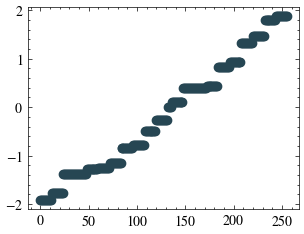

In [6]:
plt.plot(eigenvalues, 'o')

#### Prepare the degenerate eigenstates

In [7]:
def find_degenerate_manifolds(eigenvalues, decimals: int = 6):
    degeneracies = defaultdict(list)
    for i, eig in enumerate(eigenvalues):
        key = round(eig, decimals)
        degeneracies[key].append(i)
    return degeneracies

def find_degenerate_manifolds_sorted(eigenvalues, tol: float = 1e-8, decimals: int = 6):
    groups          = defaultdict(list)
    current_group   = [0]
    for i in range(1, len(eigenvalues)):
        if abs(eigenvalues[i] - eigenvalues[i - 1]) < tol:
            current_group.append(i)
        else:
            key             = round(eigenvalues[i - 1], decimals)
            groups[key]     = current_group
            current_group   = [i]
    key             = round(eigenvalues[-1], decimals)
    groups[key]     = current_group  # add the last group
    return groups

degeneracies = find_degenerate_manifolds_sorted(eigenvalues)
# degeneracies = find_degenerate_manifolds(eigenvalues)
degeneracies

defaultdict(list,
            {-1.917662: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
             -1.767666: [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
             -1.376022: [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
             -1.375925: [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
             -1.2727: [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
             -1.266382: [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71],
             -1.150644: [72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83],
             -0.835083: [84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95],
             -0.783031: [96,
              97,
              98,
              99,
              100,
              101,
              102,
              103,
              104,
              105,
              106,
              107],
             -0.50184: [108,
              109,
              110,
              111,
              112,
              113,
              114,
              115,
    

In [8]:
entropies           = {
    "original"      : EntropyStats(),
    "mix_states"    : EntropyStats(),
    "mix_dens_mat"  : EntropyStats()
}

In [9]:
# Select a random manifold from the degeneracies
manifold                = np.random.choice(list(degeneracies.keys()))
manifold_indices        = degeneracies[manifold]
logger.info(f"Selected manifold: {manifold}")

# original states
manifold_states         = eigenvectors[:, manifold_indices]
manifold_org_jax        = jax.numpy.array(manifold_states)
logger.info(f"Original states shape: {manifold_org_jax.shape}")

# save the original states
entropies["original"]   = EntropyStats()  # reset for original states
for state in manifold_org_jax.T:
    schmidt_values, _       = schmidt_jax(state, dimA, dimB, use_eig=False)
    entropy                 = vn_entropy_jax(schmidt_values)
    entropies["original"].values.append(float(entropy))
entropies["original"].maximum       = max(entropies["original"].values)
entropies["original"].minimum       = min(entropies["original"].values)
entropies["original"].mean          = np.mean(entropies["original"].values)
entropies["original"].std           = np.std(entropies["original"].values)
entropies["original"].indices       = manifold_indices
logger.info(f"Original entropies: {entropies['original'].values}")

28_07_2025_18-12_02 [INFO] Selected manifold: 0.40446
28_07_2025_18-12_02 [INFO] Original states shape: (256, 12)
28_07_2025_18-12_02 [INFO] Original entropies: [2.276410493675114, 2.16469639200435, 2.3305621443595963, 2.265640266862148, 2.3440121823991054, 2.279132386110802, 2.2101081546099053, 2.2818940973491952, 2.214461985420183, 2.2074653044076844, 2.292787895110818, 2.1972905799273956]


In [10]:
# mix the states using Haar random unitaries
entropies["mix_states"] = EntropyStats()  # reset for mixed states
gamma_mix               = config["ENV"]["Gamma"]
print(f"Mixing states with Haar random unitary (gamma={gamma_mix})")
if iscpx:
    haar_unitary            = jnp.array(QuadraticSelection.haar_random_unitary(gamma=gamma_mix), dtype=jnp.complex128)
else:
    # take simple random unitary if not complex
    # this is a Haar random unitary for real matrices
    haar_unitary            = jnp.array(random_real_orthogonal(manifold_org_jax.shape[1], seed=master_seed), dtype=jnp.float64)
mainifold_mix_st_jax    = manifold_org_jax @ haar_unitary
logger.info(f"Mixed states shape: {mainifold_mix_st_jax.shape}")
for state in mainifold_mix_st_jax.T:
    schmidt_values, _   = schmidt_jax(state, dimA, dimB, use_eig=False)
    entropy             = vn_entropy_jax(schmidt_values)
    entropies["mix_states"].values.append(entropy)
entropies["mix_states"].maximum     = max(entropies["mix_states"].values)
entropies["mix_states"].minimum     = min(entropies["mix_states"].values)
entropies["mix_states"].mean        = np.mean(entropies["mix_states"].values)
entropies["mix_states"].std         = np.std(entropies["mix_states"].values)
entropies["mix_states"].indices     = manifold_indices
logger.info(f"Mixed states entropies: {entropies['mix_states'].values}")

Mixing states with Haar random unitary (gamma=12)
28_07_2025_18-12_02 [INFO] Mixed states shape: (256, 12)
28_07_2025_18-12_02 [INFO] Mixed states entropies: [Array(2.2813631, dtype=float64), Array(2.15575216, dtype=float64), Array(2.19118724, dtype=float64), Array(2.27743688, dtype=float64), Array(2.28146446, dtype=float64), Array(2.19801225, dtype=float64), Array(2.29700111, dtype=float64), Array(2.28035302, dtype=float64), Array(2.22968618, dtype=float64), Array(2.24818089, dtype=float64), Array(2.15820861, dtype=float64), Array(2.22563837, dtype=float64)]


In [11]:
# mix the density matrices using the same Haar random unitaries
entropies["mix_density"]    = EntropyStats()  # reset for mixed density matrices
gamma_mix                   = config["ENV"]["Gamma"]
# coeff from the Haar random unitary
coefficients                = jnp.array([1 / jnp.sqrt(gamma_mix)] * gamma_mix, dtype=dtype_jax) @ haar_unitary
print(f"Coefficients shape: {coefficients.shape}, norm= {jnp.linalg.norm(coefficients)}")

rho_jax_mix                 = jnp.zeros((dimA, dimA), dtype=dtype_jax)
for i, state in enumerate(manifold_org_jax.T):
    rho_state       = rho_jax(state, dimA, dimB)
    rho_jax_mix    += coefficients[i]**2 * rho_state
# eigenvalues of rho
rho_mix_eigval              = jnp.linalg.eigvalsh(rho_jax_mix)
entropies["mix_dens_mat"].values    = []
entropies["mix_dens_mat"].indices   = manifold_indices
entropies["mix_dens_mat"].values    = [jnp.real(vn_entropy_jax(rho_mix_eigval))] * len(manifold_indices)
entropies["mix_dens_mat"].maximum   = max(entropies["mix_dens_mat"].values)
entropies["mix_dens_mat"].minimum   = min(entropies["mix_dens_mat"].values)
entropies["mix_dens_mat"].mean      = np.mean(entropies["mix_dens_mat"].values)
entropies["mix_dens_mat"].std       = np.std(entropies["mix_dens_mat"].values)
logger.info(f"Mixed density matrices entropies: {entropies['mix_dens_mat'].values}")

Coefficients shape: (12,), norm= 1.0000000000000002
28_07_2025_18-12_03 [INFO] Mixed density matrices entropies: [Array(2.6881722, dtype=float64), Array(2.6881722, dtype=float64), Array(2.6881722, dtype=float64), Array(2.6881722, dtype=float64), Array(2.6881722, dtype=float64), Array(2.6881722, dtype=float64), Array(2.6881722, dtype=float64), Array(2.6881722, dtype=float64), Array(2.6881722, dtype=float64), Array(2.6881722, dtype=float64), Array(2.6881722, dtype=float64), Array(2.6881722, dtype=float64)]


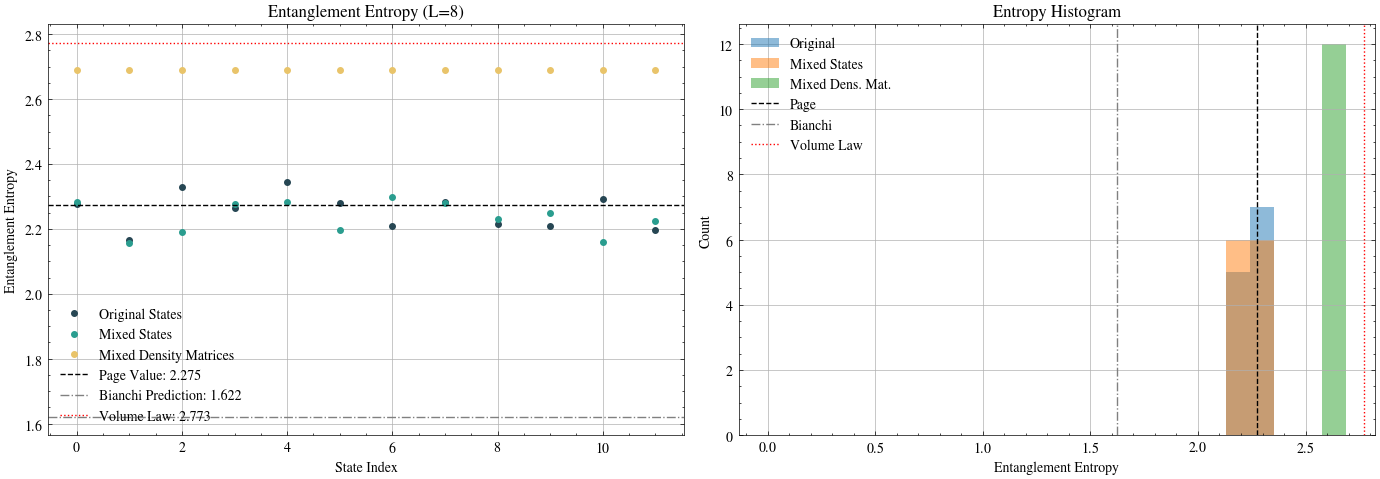

In [12]:
page_value          = EntropyPredictions.Mean.page(da = config["BIPARTITION"]["dimA"], db = config["BIPARTITION"]["dimB"])
gaussian_value      = EntropyPredictions.Mean.random_gaussian_th(L=config["ENV"]["Ns"], f=config["BIPARTITION"]["f"])
volume_value        = np.log(2) * config["BIPARTITION"]["f"] * config["ENV"]["Ns"]  # Volume law prediction
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={"width_ratios": [1, 1]})

# Extract values
vals_original       = np.asarray(entropies["original"].values)
vals_mix_states     = np.asarray(entropies["mix_states"].values)
vals_mix_dens       = np.asarray(entropies["mix_dens_mat"].values)

# Left: line plot
axs[0].plot(vals_original, 'o', label='Original States', markersize=4)
axs[0].plot(vals_mix_states, 'o', label='Mixed States', markersize=4)
axs[0].plot(vals_mix_dens, 'o', label='Mixed Density Matrices', markersize=4)
axs[0].axhline(page_value, color='black', linestyle='--', label=f'Page Value: {page_value:.3f}')
axs[0].axhline(gaussian_value, color='gray', linestyle='-.', label=f'Bianchi Prediction: {gaussian_value:.3f}')
axs[0].axhline(volume_value, color='red', linestyle=':', label=f'Volume Law: {volume_value:.3f}')
axs[0].set_xlabel('State Index')
axs[0].set_ylabel('Entanglement Entropy')
axs[0].set_title(f'Entanglement Entropy (L={L})')
axs[0].legend()
axs[0].grid()

# Right: histogram
all_vals = [
    (vals_original, "Original"),
    (vals_mix_states, "Mixed States"),
    (vals_mix_dens, "Mixed Dens. Mat.")
]
colors = ['tab:blue', 'tab:orange', 'tab:green']
bins = np.linspace(0, max([v.max() for v, _ in all_vals]), 25)

for (vals, label), color in zip(all_vals, colors):
    axs[1].hist(vals, bins=bins, alpha=0.5, label=label, color=color)

axs[1].axvline(page_value, color='black', linestyle='--', label='Page')
axs[1].axvline(gaussian_value, color='gray', linestyle='-.', label='Bianchi')
axs[1].axvline(volume_value, color='red', linestyle=':', label='Volume Law')
axs[1].set_xlabel('Entanglement Entropy')
axs[1].set_ylabel('Count')
axs[1].set_title('Entropy Histogram')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

### Define the loss functions


In [13]:
def normalize_state(c):
    return c / jnp.linalg.norm(c)

def loss_entanglement_unitary(unitary: jnp.array, prepared_states: jnp.array):
    new_states          = prepared_states @ unitary
    dim_a               = config["BIPARTITION"]["dimA"]
    dim_b               = config["BIPARTITION"]["dimB"]
    schmidt_values      = jnp.array([schmidt_jax(state, dim_a, dim_b, use_eig=False)[0] for state in new_states.T])
    entropies           = [vn_entropy_jax(s) for s in schmidt_values]
    return jnp.mean(jnp.array(entropies))

def loss_entanglement_single(coefficients: jnp.array, prepared_states: jnp.array):
    """
    Loss function for a vector of coefficients applied to prepared states.
    """
    dim_a               = config["BIPARTITION"]["dimA"]
    dim_b               = config["BIPARTITION"]["dimB"]
    # compute mixed state vector consisting of \sum _i c_i |psi_i>
    mixed_state         = prepared_states @ coefficients
    # normalize the mixed state
    mixed_state         = normalize_state(mixed_state)
    # compute the Schmidt values and entropy
    schmidt_values, _   = schmidt_jax(mixed_state, dim_a, dim_b, use_eig=False)
    entropy             = vn_entropy_jax(schmidt_values)
    return entropy

loss_entanglement_single_jit    = jax.jit(loss_entanglement_single)
loss_entanglement_unitary_jit   = jax.jit(loss_entanglement_unitary)


### Create standard gradient descent optimizer that minimizes the entanglement entropy

In [14]:
@jax.jit
def step_simple(coeffs, prepared_states, lr = 0.01):
    loss_fn     = lambda c: loss_entanglement_single_jit(c, prepared_states)
    loss        = loss_fn(coeffs)
    grad        = jax.grad(loss_fn)(coeffs)
    coeffs_new  = coeffs - lr * grad
    return normalize_state(coeffs_new), loss


@jax.jit
def step_simple_realimag(coeffs, prepared_states, lr):
    def loss_wrapped(real_imag, prepared_states):
        # Reconstruct complex coefficients
        c           = real_imag[:real_imag.size//2] + 1j * real_imag[real_imag.size//2:]
        return loss_entanglement_single_jit(c, prepared_states)
    
    real_imag   = jnp.concatenate([jnp.real(coeffs), jnp.imag(coeffs)])
    grad        = jax.grad(loss_wrapped)(real_imag, prepared_states)

    # Gradient descent in real+imag space
    updated     = real_imag - lr * grad
    c_new       = updated[:coeffs.size] + 1j * updated[coeffs.size:]
    return normalize_state(c_new), loss_entanglement_single_jit(c_new, prepared_states)

def optimize_simple(prepared_states, lr = 0.01, n_steps = 500, seed = master_seed, is_cpx_simple = iscpx, verbose_every = 50):
    """
    Simple optimization loop for the coefficients.
    
    Parameters:
    - prepared_states: JAX array of prepared states.
    - lr: Learning rate for the optimization.
    - n_steps: Number of optimization steps.
    - seed: Random seed for reproducibility.
    
    Returns:
    - Final coefficients and loss history.
    """
    if is_cpx_simple:
        dtype_in        = jnp.complex64
        key_re, key_im  = jax.random.split(jax.random.PRNGKey(seed))
        # simple random coefficients for complex case
        coeffs_re       = jax.random.normal(key_re, (prepared_states.shape[1],), dtype=dtype_in)
        coeffs_im       = jax.random.normal(key_im, (prepared_states.shape[1],), dtype=dtype_in)
        coeffs          = coeffs_re + 1j * coeffs_im
    else:
        dtype_in        = jnp.float32
        key             = jax.random.PRNGKey(seed)
        coeffs          = jax.random.normal(key, (prepared_states.shape[1],), dtype=dtype_in)
    # ensure the coefficients are normalized
    coeffs          = normalize_state(coeffs)
    losses          = []

    if is_cpx_simple:
        for step in range(n_steps):
            coeffs, loss    = step_simple_realimag(coeffs, prepared_states, lr)
            losses.append(loss)
            
            if step % verbose_every == 0:
                logger.info(f"Step {step}, Loss: {loss:.4f}")
    else:
        for step in range(n_steps):
            coeffs, loss    = step_simple(coeffs, prepared_states, lr)
            losses.append(loss)
            
            if step % verbose_every == 0:
                logger.info(f"Step {step}, Loss: {loss:.4f}")
    
    return coeffs, losses

In [15]:
coeffs, loss = optimize_simple(mainifold_mix_st_jax, lr=0.01, n_steps=2000, seed=master_seed, is_cpx_simple=iscpx, verbose_every=100)
logger.info(f"Final coefficients: {coeffs}")

28_07_2025_18-12_03 [INFO] Step 0, Loss: 2.3347
28_07_2025_18-12_04 [INFO] Step 100, Loss: 2.2503
28_07_2025_18-12_04 [INFO] Step 200, Loss: 2.1528
28_07_2025_18-12_04 [INFO] Step 300, Loss: 2.0819
28_07_2025_18-12_04 [INFO] Step 400, Loss: 2.0531
28_07_2025_18-12_04 [INFO] Step 500, Loss: 2.0420
28_07_2025_18-12_04 [INFO] Step 600, Loss: 2.0363
28_07_2025_18-12_05 [INFO] Step 700, Loss: 2.0321
28_07_2025_18-12_05 [INFO] Step 800, Loss: 2.0279
28_07_2025_18-12_05 [INFO] Step 900, Loss: 2.0226
28_07_2025_18-12_05 [INFO] Step 1000, Loss: 2.0152
28_07_2025_18-12_05 [INFO] Step 1100, Loss: 2.0056
28_07_2025_18-12_06 [INFO] Step 1200, Loss: 1.9960
28_07_2025_18-12_06 [INFO] Step 1300, Loss: 1.9874
28_07_2025_18-12_06 [INFO] Step 1400, Loss: 1.9805
28_07_2025_18-12_06 [INFO] Step 1500, Loss: 1.9757
28_07_2025_18-12_06 [INFO] Step 1600, Loss: 1.9729
28_07_2025_18-12_06 [INFO] Step 1700, Loss: 1.9716
28_07_2025_18-12_07 [INFO] Step 1800, Loss: 1.9710
28_07_2025_18-12_07 [INFO] Step 1900, Loss:

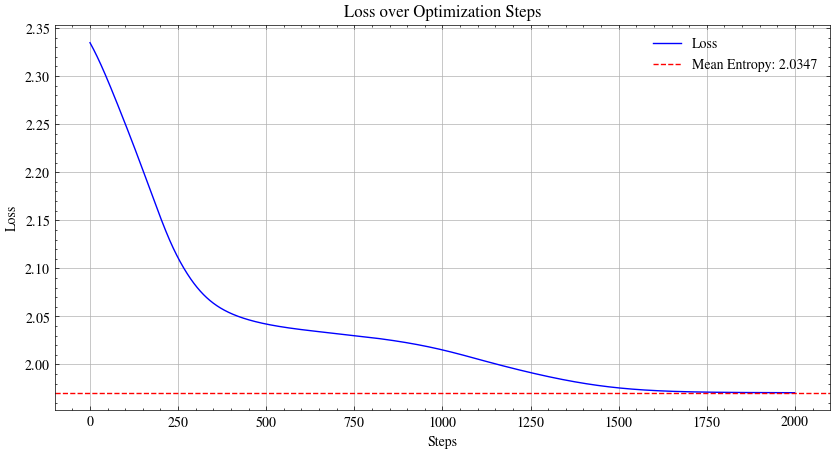

In [16]:

# Plot the loss
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Loss', color='blue')
plt.axhline(np.min(loss), color='red', linestyle='--', label=f'Mean Entropy: {np.mean(loss):.4f}')
plt.title('Loss over Optimization Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.grid()
plt.legend()

In [17]:
# check the final energy of the mixed state
final_mixed_state = mainifold_mix_st_jax @ coeffs
final_energy = jnp.vdot(final_mixed_state, hamil @ final_mixed_state)
logger.info(f"Final energy of the mixed state: {final_energy:.6f}, while was - {manifold}")

28_07_2025_18-12_08 [INFO] Final energy of the mixed state: 0.404460, while was - 0.40446


### Create standard gradient descent optimizer that minimizes the entanglement entropy using density matrices

### Reinforcement learning optimizer for the entanglement entropy

In [ ]:
from functools import partial

@partial(jax.jit, static_argnums=(4,))
def _apply_complex_givens_rotation_jax(
            V     : jnp.ndarray, 
            i     : int, 
            j     : int, 
            theta : float,
            dim   : int,
            phi   : float) -> jnp.ndarray:
        """
        Apply a complex Givens rotation on V of size (dim x dim).

        Rotation matrix R acts on the (i, j) suabspace as:
        R_ii = cos(theta)
        R_jj = cos(theta)
        R_ij = -sin(theta) * exp(i * phi)
        R_ji = sin(theta) * exp(-i * phi)

        Parameters
        ----------
        V     : (dim, dim) complex ndarray
            Unitary matrix to rotate.
        i, j  : int
            Indices to rotate between.
        theta : float
            Rotation angle in radians.
        phi   : float
            Phase angle in radians.
        dim   : int
            Dimension of the unitary matrix.

        Returns
        -------
        jnp.ndarray
            Rotated matrix V_new = V @ R
        """
        R = jnp.eye(dim, dtype=jnp.complex64)
        c = jnp.cos(theta)
        s = jnp.sin(theta)
        exp_i_phi = jnp.exp(1j * phi)
        exp_neg_i_phi = jnp.exp(-1j * phi)

        R = R.at[i, i].set(c)
        R = R.at[j, j].set(c)
        R = R.at[i, j].set(-s * exp_i_phi)
        R = R.at[j, i].set(s * exp_neg_i_phi)

        return V @ R

@partial(jax.jit, static_argnums=(4,))
def _apply_givens_rotation_jax(V: jnp.ndarray, i: int, j: int, theta: float, M: int = 2, phi: float = 0.0):
    """
    Applies a Givens rotation to a JAX matrix or vector.

    Parameters:
        V (jnp.ndarray): The input matrix or vector.
        i (int): First rotation index.
        j (int): Second rotation index.
        theta (float): Rotation angle in radians.
        M (int): Size of the identity matrix (used for constructing rotation). Default is 2.

    Returns:
        jnp.ndarray: Rotated output.
    """
    R       = jnp.eye(M, dtype=V.dtype)
    c, s    = jnp.cos(theta), jnp.sin(theta)

    R = R.at[i, i].set(c)
    R = R.at[j, j].set(c)
    R = R.at[i, j].set(-s)
    R = R.at[j, i].set(s)

    return V @ R

class QuantumEntanglementEnv(gym.Env):
    """
    A gymnasium.Env for minimizing entanglement entropy.

    - Observation   : Flattened complex unitary matrix V (real and imag parts concatenated).
    - Action        : A discrete integer mapping to a specific Givens rotation (i, j, angle_idx).
    - Reward        : The reduction in total entanglement entropy from the previous step.
    """
    metadata        = {'render_modes': ['human'], 'render_fps': 4}
    
    def __init__(self,
                config              : dict,
                train_states        : jnp.ndarray,                                      # States to train on (shape: [dim_a * dim_b, Gamma])
                org_states          : Optional[jnp.ndarray]                 = None,     # Original states in the environment (shape: [dim_a * dim_b, Gamma]) - only Gamma matters for us
                K                   : int                                   = 10,       # Discrete action space size
                max_steps           : int                                   = 1000,     # Maximum number of steps in the environment
                reg_lambda_norm     : float                                 = 0.1,
                dtype               : jnp.dtype                             = dtype_jax # Data type for JAX arrays (complex or real)
                ):     # Regularization parameter for norm penalty
        
        # Initialize the environment with the given parameters.
        super().__init__()
        
        # Validate the input parameters
        la_in                       = config.get("BIPARTITION", {}).get("La", None)
        lb_in                       = config.get("BIPARTITION", {}).get("Lb", None)

        if not isinstance(la_in, int) or la_in <= 0:
            raise ValueError("dim_a must be a positive integer.")
        if not isinstance(lb_in, int) or lb_in <= 0:
            raise ValueError("dim_b must be a positive integer.")
        if not isinstance(K, int) or K <= 0:
            raise ValueError("K must be a positive integer.")
        if not isinstance(train_states, jnp.ndarray) or train_states.ndim != 2:
            raise ValueError("train_states must be a 2D JAX array (shape: [dim_a * dim_b, Gamma]).")
        
        #!TODO: Modify this so we can use masks rather than subsystem A and B on the left and right
        self.dtype                      = dtype_jax if dtype is None else dtype                     # Data type for JAX arrays (complex or real)
        self.iscomplex                  = (self.dtype == jnp.complex128) or (self.dtype == jnp.complex64)
        self.org_states                 = org_states if org_states is not None else train_states    # Use train_states if org_states is None
        self.gamma_dim                  = train_states.shape[1]                                     # Number of coefficients (Gamma) in the environment
        self.full_nh                    = train_states.shape[0]                                     # Full Hilbert space dimension (dim_a * dim_b)
        self.ns                         = int(np.log2(self.full_nh))                                # Number of qubits (log2 of full Hilbert space dimension)        
        self.dim_a                      = 2**la_in                                                  # Dimension of subsystem A (left partition) 
        self.dim_b                      = 2**lb_in                                                  # Dimension of subsystem B (right partition)\
        self.la                         = la_in                                                     # Number of qubits in subsystem A
        self.lb                         = lb_in                                                     # Number of qubits in subsystem B
        self.train_states               = train_states.astype(dtype_jax)                            # States to train on (shape: [dim_a * dim_b, Gamma])
        
        # environment parameters
        self.max_steps                  = max_steps                                                 # Maximum number of steps in the environment
        self.reg_lambda_norm            = reg_lambda_norm                                           # Regularization parameter for norm penalty
        self.train_states_learn         = jnp.array(self.train_states, dtype=self.dtype)            # States to learn on (shape: [dim_a * dim_b, Gamma])
        
        # some entropy predictions
        self.page_value                 = EntropyPredictions.Mean.page(da=self.dim_a, db=self.dim_b)
        self.gaussian_value             = EntropyPredictions.Mean.random_gaussian_th(L=self.ns, f=self.la / self.ns)
        self.volume_value               = np.log(2) * (self.la / self.ns)

        # Define the discrete action space for rotations on Gamma coefficients
        self._delta_theta               = jnp.pi / (2 * K) if K > 0 else 0
        # phase_angles                    = [0.0, jnp.pi/2, jnp.pi, 3*jnp.pi/2] # discrete phases - should I add more?
        phase_angles                    = [0.0]

        self.action_map                 = []
        for i, j in it.combinations(range(self.Gamma), 2):
            for angle_idx in range(-K, K + 1):
                theta = angle_idx * self._delta_theta
                for phi in phase_angles:
                    self.action_map.append({'i': i, 'j': j, 'theta': theta, 'phi': phi})
        
        # Define Gym spaces
        self.action_space               = gym.spaces.Discrete(len(self.action_map))
        obs_shape                       = (2 * Gamma * Gamma,)              # Flattened observation shape: real and imaginary parts of coefficients
        self.observation_space          = gym.spaces.Box(low=-1.0, high=1.0, shape=obs_shape, dtype=np.float32)
        self.givens                     = (_apply_givens_rotation_jax) if not self.iscomplex else _apply_complex_givens_rotation_jax
        
        
        # Environment state variables
        self.V                          = None                              # Unitary matrix V
        self.R                          = None                              # Stores the combined rotation matrix
        self.current_total_entropy      = None                              # Current total entanglement entropy         
        self.current_total_entropy_min  = None                              # Minimum total entanglement entropy observed
        self.current_total_entropy_max  = None                              # Maximum total entanglement entropy observed
        self.transformed_states         = None                              # Transformed states after applying the unitary V
        self.step_count                 = 0                                 # Step counter - tracks the number of steps taken in the environment
        self.config                     = config                            # Configuration dictionary for the environment
        self.org_states_info            = {}                                # Information about the original states (entropies, min, max, etc.)
        self.uniform_coefficients       = jnp.array([1 / jnp.sqrt(self.Gamma)] * self.Gamma, dtype=self.dtype)  # Uniform coefficients for the initial state
        
    #############################################
    #! Properties
    #############################################
    
    @property
    def Gamma(self) -> int:
        '''
        Returns the number of coefficients (Gamma) in the environment.
        Returns:
            int: The number of coefficients (Gamma).
        '''
        return self.gamma_dim

    #############################################
    #! Calculators
    #############################################
    
    def _calculate_total_entropy(self, V: jnp.ndarray) -> jnp.ndarray:
        '''
        Calculate the total entanglement entropy for the transformed states after applying the unitary V.
        Parameters:
            V (jnp.ndarray):
                The unitary matrix V to apply to the original states.
        Returns:
            total_entropy (jnp.ndarray):
                The total entanglement entropy of the transformed states.
        '''
        
        # get the coefficients from the unitary V
        coefficients = self.uniform_coefficients @ V
        entropy      = loss_entanglement_single_jit(coefficients, self.train_states_learn)
        return entropy * self.Gamma, entropy, entropy, jnp.array([entropy] * self.Gamma, dtype=self.dtype)
        
        # 1. Create the final states by mixing the basis states: \psi = org_states_learn @ V
        # Shape: (N, Γ) @ (Γ, Γ) -> (N, Γ)
        self.transformed_states = self.train_states_learn @ V
        
        # 2. Calculate entropy for each of the gamma columns (states)
        entropies = jax.vmap(lambda state: vn_entropy_jax(schmidt_jax(state, self.dim_a, self.dim_b, use_eig=False)[0]), in_axes=1)(self.transformed_states)
        
        # 3. Return the total entropy, minimum, maximum, and individual entropies
        return jnp.min(entropies), jnp.min(entropies), jnp.max(entropies), entropies

    def _reset_states_info(self):
        '''
        Resets the original states information to an empty state.
        This method is used to clear the original states information when resetting the environment.
        '''
        self.org_states_info = {
            'original'          : [],                               # Original states entropies
            'minimum'           : float('inf'),                     # Minimum entropy of original states
            'maximum'           : float('-inf'),                    # Maximum entropy of original states
            'average'           : 0.0,                              # Average entropy of original states
            'mixed'             : [],                               # Mixed states entropies
            'minimum_mixed'     : float('inf'),                     # Minimum entropy of mixed states                                 
            'maximum_mixed'     : float('-inf'),                    # Maximum entropy of mixed states
            'average_mixed'     : 0.0,
            'submanifold_mp'    : np.zeros((self.Gamma,), dtype=int)# Submanifold mapping for entropy values
        }
        
        # go through the original states and calculate the entropies
        for g in range(self.Gamma):
            state               = self.train_states[:, g]
            schmidt_values, _   = schmidt_jax(state, self.dim_a, self.dim_b, use_eig=False)
            entropy             = vn_entropy_jax(schmidt_values)
            
            #! fill up the mixed states info if it is empty
            self.org_states_info['mixed'].append(entropy)
            self.org_states_info['minimum_mixed']   = min(self.org_states_info['minimum_mixed'], entropy)
            self.org_states_info['maximum_mixed']   = max(self.org_states_info['maximum_mixed'], entropy)
            self.org_states_info['average_mixed']  += entropy / self.Gamma
            
            state               = self.org_states[:, g]
            schmidt_values, _   = schmidt_jax(state, self.dim_a, self.dim_b, use_eig=False)
            entropy             = vn_entropy_jax(schmidt_values)
            
            #! fill out the original states info if it is empty
            self.org_states_info['original'].append(entropy)
            self.org_states_info['minimum']         = min(self.org_states_info['minimum'], entropy)
            self.org_states_info['maximum']         = max(self.org_states_info['maximum'], entropy)
            self.org_states_info['average']        += entropy / self.Gamma
    
    #############################################
    #! Environment API Methods
    #############################################

    def reset(self, seed: int = None, options: Dict = None):
        '''
        Resets the environment to an initial state.
        Parameters:
            seed (int, optional):
                Random seed for reproducibility. If None, a random seed will be generated.
            options (Dict, optional):
                Additional options for resetting the environment (not used in this implementation).
        Returns:
            obs (np.ndarray):
                The initial observation of the environment, which is a flattened array of the real and imaginary parts of the coefficients.
            info (Dict):
                Additional information about the reset state, such as the initial loss value.
        Raises:
            ValueError:
                If the initial coefficients do not match the expected shape or norm.
        '''
        super().reset(seed=seed)
        
        # The agent's state V is a ΓxΓ identity matrix
        self.step_count                 = 0
        self.V                          = jnp.eye(self.Gamma, dtype=self.dtype)
        self.R                          = jnp.eye(self.Gamma, dtype=self.dtype)

        if len(self.org_states_info) == 0:
            self._reset_states_info() # Reset the original states info if it is empty
        
        self.current_total_entropy      = self.org_states_info['average_mixed'] * self.Gamma
        self.current_total_entropy_min  = self.org_states_info['minimum_mixed']
        self.current_total_entropy_max  = self.org_states_info['maximum_mixed']
        self.current_entropies          = jnp.array(self.org_states_info['mixed'], dtype=self.dtype)
        
        # set the transformed states again
        obs                             = jnp.concatenate([self.V.real.flatten(), self.V.imag.flatten()])
        info                            = { 'total_entropy' : self.current_total_entropy,
                                            'min_entropy'   : self.current_total_entropy_min, 
                                            'max_entropy'   : self.current_total_entropy_max }
        return np.array(obs), info

    def step(self, action: int):
        """Performs one step in the environment."""
        
        # Update the step count
        self.step_count        += 1
        
        # Action parameters are for a rotation in given (i, j) subspace
        action_params           = self.action_map[action]
        i, j, theta, phi        = action_params['i'], action_params['j'], action_params['theta'], action_params.get('phi', 0.0)

        # Build new gamma x gamma unitary matrix V
        new_V                   = self.givens(self.V, i, j, theta, self.Gamma, phi) # Apply the Givens rotation to the current unitary V

        # Calculate new entropy using the black-box function
        new_total, new_min, new_max, new_all = self._calculate_total_entropy(new_V)

        entropy_reduction       = self.current_total_entropy - new_total
        normalized_reward       = entropy_reduction / self.volume_value
        reward_entropy          = normalized_reward
        
        #! Regularization to penalize variance in the transformed states
        variance_penalty        = 0
        # if self.org_states_info['submanifold_mp'] is not None:
        #     num_submanifolds = len(self.org_states_info['submanifold_mp'])
        #     for i in range(num_submanifolds):
        #         entropies_in_submanifold = individual_entropies[self.org_states_info['submanifold_mp'] == i]
        #         if len(entropies_in_submanifold) > 0:
        #             variance_penalty += jnp.var(entropies_in_submanifold)
        # variance_penalty   /= num_submanifolds if num_submanifolds > 0 else 1
        lambda_variance         = 0.2
        reward_entropy         -= lambda_variance * variance_penalty        # Regularization term to penalize variance in entropies

        # Overlaps with the original states
        # overlaps            = jax.vmap(jnp.vdot, in_axes=(1, 1))(self.org_states, self.transformed_states)
        # overlap_penalty     = jnp.mean(jnp.abs(overlaps)**2)
        overlap_penalty          = 0.0 # Overlap penalty is not used in this implementation, but can be added if needed
        reward_entropy          -= self.reg_lambda_norm * overlap_penalty    # Regularization term to penalize overlaps

        # Update the environment state
        self.V                          = new_V
        self.R                          = self.R @ new_V    # Update the combined rotation matrix
        self.current_total_entropy      = new_total         # Update the current total entropy
        self.current_total_entropy_min  = new_min           # Update the current minimum total entropy
        self.current_total_entropy_max  = new_max           # Update the current maximum total entropy
        self.current_entropies          = new_all           # Update the current entropies for each state

        terminated                      = False
        truncated                       = self.step_count >= self.max_steps

        obs                             = jnp.concatenate([self.V.real.flatten(), self.V.imag.flatten()])
        info                            = { 'total_entropy'     : self.current_total_entropy, 
                                            'min_entropy'       : self.current_total_entropy_min,
                                            'max_entropy'       : self.current_total_entropy_max, 
                                            'variance_penalty'  : variance_penalty,
                                            'overlap_penalty'   : overlap_penalty }
        
        return obs, float(reward_entropy), terminated, truncated, info

    def render(self, mode: str = 'human'):
        """
        Render the environment's current state using the notebook logger.
        Reports:
            - step count
            - unitary-norm check (Frobenius norm / Γ)
            - total entanglement entropy
            - per-state entropy statistics (min / avg / max)
        """
        
        if mode != 'human':
            return

        # Norm check: ⟨V, V⟩ / gamma
        norm_sq     = jnp.trace(self.V @ self.V.T.conj()).real / self.Gamma

        # Log via notebook logger
        text        =   f"Step {self.step_count} | Norm(Fro/Γ): {norm_sq:.6f} | TotalEntropy: {self.current_total_entropy:.6f} " \
                        f"| per-state [min: {self.current_total_entropy_min:.6f}, max: {self.current_total_entropy_max:.6f}]"
        logger.info(text, lvl = 1, color = 'blue')

    ##############################################
    #! Sanity Check
    ##############################################
    
    def sanity(self):
        logger.title("Sanity Check: Greedy One-Step Search", desired_size=80, fill='-', color='cyan', lvl=1)
        
        #! Reset the environment to get the initial state and entropy info
        obs, info           = self.reset()  # Reset the environment to get the initial state and entropy info
        initial_entropy     = info['total_entropy']
        logger.info(f"Initial Total Entropy: {initial_entropy:.5f}", color='blue', lvl=2)

        best_reward         = -float('inf')
        best_action         = -1

        for action in range(self.action_space.n):
            # We need to simulate a step without actually changing the env state for the next loop
            action_params       = self.action_map[action]
            i, j, theta, phi    = action_params['i'], action_params['j'], action_params['theta'], action_params.get('phi', 0.0)
            
            # Apply the rotation to a copy of the current V matrix
            new_V               = _apply_complex_givens_rotation_jax(self.V, i, j, theta, phi, self.Gamma)

            # Calculate the resulting entropy and reward
            new_entropy         = self._calculate_total_entropy(new_V)[0]
            reward              = initial_entropy - new_entropy
            logger.info(f"Action {action}: Entropy after action = {new_entropy:.5f}, Reward = {reward:.5f}", color='green', lvl = 3)
            if reward > best_reward:
                best_reward = reward
                best_action = action

        logger.info(f"Best possible one-step reward: {best_reward:.5f}", color='green', lvl=2)
        logger.info(f"Achieved with action: {best_action}", color='green', lvl=2)

        if best_reward > 0:
            logger.info("SUCCESS: There are actions that immediately reduce entropy.", color='green', lvl=1)
        else:
            logger.warning("WARNING: No single action from the start reduces entropy. The problem might be too hard or the reward is ill-defined.", color='red', lvl=1)


In [19]:
from typing import NamedTuple, Sequence

class ActorCritic(nn.Module):
    """
    State-of-the-art Actor-Critic for PPO adapted to quantum control tasks.

    Policy: Gaussian distribution \(\pi_\theta(a|s)=\mathcal{N}(a; \mu_\theta(s), \mathrm{diag}(\sigma^2))\)
    Value: \(V_\phi(s)\)
    """
    action_dim: int

    @nn.compact
    def __call__(self, x: jnp.ndarray):
        
        x = nn.Dense(128)(x)
        x = nn.LayerNorm()(x)
        x = nn.tanh(x)

        x = nn.Dense(128)(x)
        x = nn.LayerNorm()(x)
        x = nn.tanh(x)
        
        x = nn.Dense(128)(x)
        x = nn.LayerNorm()(x)
        x = nn.tanh(x)
            
        # --- Actor Head ---
        logits = nn.Dense(self.action_dim, kernel_init=nn.initializers.orthogonal(0.01), name="actor_logits")(x)

        # --- Critic Head ---
        v = nn.Dense(128)(x)
        v = nn.LayerNorm()(v)
        v = nn.tanh(v)

        v = nn.Dense(128)(v)
        v = nn.LayerNorm()(v)
        v = nn.tanh(v)
        
        v = nn.Dense(1, kernel_init=nn.initializers.orthogonal(1.0), name="critic_value")(v)
        
        return logits, jnp.squeeze(v, -1)

class Transition(NamedTuple):
    done        : jnp.ndarray
    action      : jnp.ndarray
    value       : jnp.ndarray
    reward      : jnp.ndarray
    log_prob    : jnp.ndarray
    obs         : jnp.ndarray


In [20]:
class PPOAgent:
    '''
    Proximal Policy Optimization (PPO) Agent for Quantum Entanglement Minimization.
    This agent uses an Actor-Critic architecture to learn a policy that minimizes entanglement entropy in a quantum system.
    Attributes:
        obs_shape (Sequence[int]):
            The shape of the observation space, which is used to initialize the actor-critic network.
        action_dim (int):
            The dimension of the action space, which determines the output size of the actor's head in the network.
        config (Dict):
            Configuration dictionary containing hyperparameters for the agent, such as learning rate, optimizer, and GAE parameters.
    '''
    
    def __init__(self, obs_shape: Sequence[int], action_dim: int, config: Dict, dtype = jnp.float32):
        
        self.iscomplex      = (dtype == jnp.complex128) or (dtype == jnp.complex64)         # Check if the dtype is complex
        self.config         = config
        self.obs_shape      = obs_shape
        self.action_dim     = action_dim
        self.key            = jax.random.PRNGKey(config["SEED"])
        
        # Config info
        self.lr             = config.get("LEARNING_RATE", 3e-4)                             # Learning rate for the optimizer
        self.optimizer      = config.get("OPTIMIZER", optax.adam(learning_rate=self.lr))
        self.maxgrad_norm   = config.get("MAX_GRAD_NORM", 0.5)
        
        # Initialize the actor-critic network
        self.network        = ActorCritic(action_dim=self.action_dim)
        self._init_agent()
    
    def _init_agent(self):
        """Initializes the network parameters and the optimizer train state."""
        self.key, network_key   = jax.random.split(self.key)                                # Split the key for network initialization
        init_obs                = jnp.zeros((1, *self.obs_shape))                           # Initial observation for network initialization
        network_params          = self.network.init(network_key, init_obs)["params"]

        tx                      = optax.chain(optax.clip_by_global_norm(self.maxgrad_norm), self.optimizer)
        self.train_state        = TrainState.create(apply_fn=self.network.apply, params=network_params, tx=tx)

    #############################
    #! Agent API Methods
    #############################
    
    def _get_action_and_value(self, obs: np.ndarray, key: jax.random.key) -> (jnp.ndarray, jnp.ndarray, jnp.ndarray):
        """Uses the network to get an action and its value for a given observation."""
        logits, v   = self.network.apply({"params": self.train_state.params}, obs[None, :])
        logits, v   = logits[0], v[0]

        key, subkey = jax.random.split(key)
        action      = jax.random.categorical(subkey, logits)
        logp        = jax.nn.log_softmax(logits)[action]
        return int(action), float(logp), float(v), key

    def get_action(self, obs: np.ndarray):
        """Gets an action from the agent for a single observation."""
        self.key, subkey = jax.random.split(self.key)
        return self._get_action_and_value(jnp.array(obs), subkey)[:3]

    def learn(self, transitions: Transition, last_obs: Optional[np.ndarray] = None):
        """Updates the agent's parameters using a batch of transitions."""
        
        if last_obs is None:
            last_obs = transitions.obs[-1]
            
        # 1) calculate GAE
        _, _, last_val, _   = self._get_action_and_value(jnp.array(last_obs), self.key)
        advantages, returns = self._calculate_gae(transitions, last_val, self.config["GAMMA_DISCOUNT"], self.config["GAE_LAMBDA"])

        # 2) Define the update function for an entire epoch
        @jax.jit
        def _update_epoch(carry, _):
            train_state, key    = carry
            
            # Create a new permutation for shuffling data this epoch
            key, perm_key       = jax.random.split(key)
            B, M                = self.config["NUM_STEPS"], self.config["MINIBATCH_SIZE"]
            permutation         = jax.random.permutation(perm_key, B)
            
            # Reshape data for minibatching and shuffle
            batch_data = (
                transitions.obs[permutation], 
                transitions.action[permutation],
                transitions.log_prob[permutation],
                transitions.value[permutation],
                advantages[permutation],
                returns[permutation]
            )
            batch_data = jax.tree.map(
                lambda x: x.reshape((B // M, M) + x.shape[1:]), batch_data
            )

            # 3) loss + jit update
            def loss_fn(params, minibatch):
                obs_mb, act_mb, old_lp_mb, old_v_mb, adv_mb, ret_mb = minibatch
                logits, v_new = self.network.apply({"params": params}, obs_mb)
                
                # Policy Loss (with Advantage Normalization)
                adv_norm                = (adv_mb - jnp.mean(adv_mb)) / (jnp.std(adv_mb) + 1e-8)
                
                logp_all                = jax.nn.log_softmax(logits)
                logp_new                = jnp.take_along_axis(logp_all, act_mb[..., None], axis=1)[:, 0]
                ratio                   = jnp.exp(logp_new - old_lp_mb)
                
                clipped_ratio           = jnp.clip(ratio, 1 - self.config["CLIP_EPS"], 1 + self.config["CLIP_EPS"])
                policy_obj              = jnp.minimum(ratio * adv_norm, clipped_ratio * adv_norm).mean()

                # --- Value Loss ---
                # Optional: Add value clipping for more stability
                v_pred_clipped          = old_v_mb + (v_new - old_v_mb).clip(-self.config["CLIP_EPS"], self.config["CLIP_EPS"])
                v_loss_unclipped        = (v_new - ret_mb)**2
                v_loss_clipped          = (v_pred_clipped - ret_mb)**2
                v_err                   = 0.5 * jnp.maximum(v_loss_unclipped, v_loss_clipped).mean()
                # v_err = jnp.mean((v_new - ret_mb)**2)

                # Entropy Bonus
                entropy                 = -jnp.mean(jnp.sum(jnp.exp(logp_all) * logp_all, axis=1))

                # Total Objective & Loss
                J                       = policy_obj - self.config["VF_COEF"] * v_err + self.config.get("ENT_COEF", 0.01) * entropy
                loss                    = -J

                metrics                 = {
                                            "total_loss"    : loss,
                                            "policy_obj"    : policy_obj,
                                            "value_loss"    : v_err,
                                            "entropy"       : entropy
                                        }
                return loss, metrics

            # Define the update step for a single minibatch
            def _update_minibatch(state, minibatch):
                (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params, minibatch)
                new_state = state.apply_gradients(grads=grads)
                return new_state, metrics

            # Scan over all minibatches to update and collect metrics
            final_state, metrics = jax.lax.scan(_update_minibatch, train_state, batch_data)
            
            # Return the updated state and the mean metrics for this epoch
            return (final_state, key), jax.tree.map(jnp.mean, metrics)

        # 3) Run update over all epochs
        # Use lax.scan for the epoch loop as well, for JIT-compatibility
        (final_train_state, self.key), metrics  = jax.lax.scan(_update_epoch, (self.train_state, self.key), None, self.config["UPDATE_EPOCHS"])
        self.train_state                        = final_train_state
        
        # Return the mean metrics over the final epoch
        return jax.tree.map(lambda x: x.mean(), metrics)

    ############################
    #! Private Methods
    ############################

    @staticmethod
    @jax.jit
    def _calculate_gae(transitions: Transition, last_val: jnp.ndarray, gamma: float = 0.99, gae_lambda: float = 0.95):
        """Computes Generalized Advantage Estimation in a JAX-friendly way using scan."""
        
        # We need to reverse the transitions for the scan
        transitions_rev = jax.tree.map(lambda x: x[::-1], transitions)
        
        def _gae_step(carry, transition_slice):
            gae, next_val       = carry
            # A slice of the Transition tuple for one time-step
            done, value, reward = transition_slice.done, transition_slice.value, transition_slice.reward
            
            next_non_terminal   = 1.0 - done
            delta               = reward + gamma * next_val * next_non_terminal - value
            gae                 = delta + gamma * gae_lambda * next_non_terminal * gae
            
            # The new `next_val` for the next iteration is the `value` of the current state
            return (gae, value), gae

        # The initial carry for the scan is (0, last_val)
        # gae starts at 0, and the first next_val is the value of the final state (last_val)
        _, advantages_rev = jax.lax.scan(_gae_step, (0.0, last_val), transitions_rev)

        # Reverse the advantages to get them in the correct order
        advantages = advantages_rev[::-1]
        return advantages, advantages + transitions.value

In [25]:
actions_per_pair                    = 4
# ─── Configuration ──────────────────────────────────────────────────────────────
config_agent = {
    # ── Reproducibility ─────────────────────────────────────────────────────────
    "SEED"                          : master_seed,

    # ── Environment parameters ──────────────────────────────────────────────────
    "ENV": {
        "NS"                        : config["ENV"]["Ns"],
        "LA"                        : config["BIPARTITION"]["La"],
        "LB"                        : config["BIPARTITION"]["Lb"],
        "NH"                        : config["ENV"]["Nh"],
        "DIM_A"                     : config["BIPARTITION"]["dimA"],
        "DIM_B"                     : config["BIPARTITION"]["dimB"],
        "GAMMA"                     : config["ENV"]["Gamma"],
        "K"                         : actions_per_pair,     # number of discrete Givens angles per pair
        "MAX_STEPS_PER_EPISODE"     : max(1, config["ENV"]["Gamma"] // 2), # maximum number of steps per episode
    },

    # ── Training loop ───────────────────────────────────────────────────────────
    "TRAIN": {
        "NUM_UPDATES"               : 50,                       # number of updates to perform
        "NUM_STEPS"                 : 256,                      # number of steps to collect before updating the agent
        "UPDATE_EPOCHS"             : 4,
        "MAX_GRAD_NORM"             : 0.5,                      # maximum gradient norm for clipping
        "MINIBATCH_SIZE"            : 32,                       # size of each minibatch
    },

    # ── PPO hyper‐parameters ─────────────────────────────────────────────────────
    "PPO": {
        "LEARNING_RATE"             : 1e-4,
        "CLIP_EPS"                  : 0.2,
        "VF_COEF"                   : 0.5,
        "ENT_COEF"                  : 0.01,
        "GAE_LAMBDA"                : 0.95,
        "GAMMA_DISCOUNT"            : 0.99,
        "UPDATE_EPOCHS"             : 4,        # Number of epochs to update the agent per batch
        "SEED"                      : 42,       # Seed for reproducibility, special for the PPO agent
    },
}

# Calculate derived parameters to ensure consistency
total_training_steps        = config_agent["TRAIN"]["NUM_UPDATES"] * config_agent["TRAIN"]["UPDATE_EPOCHS"] * (config_agent["TRAIN"]["NUM_STEPS"] // config_agent["ENV"]["MAX_STEPS_PER_EPISODE"])

# ─── Initialize the environment ────────────────────────────────────────────────
data_org_jax, data_mix_jax, entropy_values = manifold_org_jax, mainifold_mix_st_jax, entropies["mix_states"].values

logger.title("RL Environment for Quantum Entanglement", desired_size=80, fill='#', color='red')
logger.info(f"Initialized environment with parameters: {config_agent['ENV']}", lvl=1, color='green')

# ─── Create the environment ───────────────────────────────────────────────────
logger.info("Initializing the environment...", lvl=1, color='blue')
env = QuantumEntanglementEnv(
    config              = config,
    train_states        = data_mix_jax,
    org_states          = data_org_jax,
    K                   = config_agent["ENV"]["K"],   
    max_steps           = config_agent["ENV"]["MAX_STEPS_PER_EPISODE"],   
    reg_lambda_norm     = 0.1,
    dtype               = jnp.float32
)

ppo_config              = {**config_agent["PPO"], **config_agent["TRAIN"]}
agent = PPOAgent(
    obs_shape           = env.observation_space.shape,
    action_dim          = env.action_space.n,
    config              = ppo_config,
    dtype               = jnp.float32
)

28_07_2025_18-18_42 [INFO] ####################RL Environment for Quantum Entanglement####################
28_07_2025_18-18_42 [INFO] 	->Initialized environment with parameters: {'NS': 8, 'LA': 4, 'LB': 4, 'NH': 256, 'DIM_A': 16, 'DIM_B': 16, 'GAMMA': 12, 'K': 4, 'MAX_STEPS_PER_EPISODE': 6}
28_07_2025_18-18_42 [INFO] 	->Initializing the environment...


In [27]:
# ─── Training Loop ─────────────────────────────────────────────────────────────
logger.info("Starting training loop...", lvl=1, color='green')

obs, info       = env.reset(seed=config["SEED"])
all_rewards     = []
all_entropies   = []
num_updates     = config_agent["TRAIN"]["NUM_UPDATES"]
logger.info(f"Total updates planned: {num_updates}", lvl=2, color='purple')


# ─── Learning Rate Schedule ────────────────────────────────────────────────────
lr_schedule     = optax.warmup_cosine_decay_schedule(
    init_value      =   0.0,
    peak_value      =   1e-4,
    warmup_steps    =   int(total_training_steps * 0.1), # Use 10% of steps to warm up
    decay_steps     =   int(total_training_steps * 0.9)  # Use the rest to decay
)
config_agent["PPO"]["LEARNING_RATE"] = lr_schedule

# Main training loop
sys.stdout.flush()
pbar = tqdm(total=num_updates, desc="Training Progress", unit="update", colour='blue')
pbar.reset()
for update in range(num_updates):
    
    # 1) Rollout Phase - collect transitions and store them
    storage         = []
    episode_reward  = 0.0
    info            = {}
    for ii in range(config_agent["TRAIN"]["NUM_STEPS"]):
        # Get action, value, and log_prob from the agent
        action, value, log_prob                         = agent.get_action(obs)

        # Step the environment
        next_obs, reward, terminated, truncated, info   = env.step(int(action))
        done                                            = terminated or truncated
        episode_reward                                 += reward
    
        # Store the transition in the storage
        storage.append(Transition(done, action, value, reward, log_prob, obs))
        obs = next_obs
        if done:
            pbar.set_postfix(
                episode_reward        = f"{episode_reward:.4f}",
                avg_reward_per_step   = f"{(episode_reward / env.step_count):.4f}",
                avg_entropy           = f"{(info['total_entropy'] / env.Gamma):.4f}",
                min_state_entropy     = f"{info['min_entropy']:.4f}",
                max_state_entropy     = f"{info['max_entropy']:.4f}",
                init_avg_entropy      = f"{entropies['original'].mean:.4f}",
                init_avg_mixed_entropy= f"{entropies['mix_states'].mean:.4f}",
                steps                 = env.step_count
            )
            all_rewards.append(env.step_count * reward) # Simple proxy for episode return
            all_entropies.append(info['total_entropy'])
            obs, info = env.reset()

    # 2) Learning Phase - update the agent with the collected transitions
    # Convert list of transitions to a batched Transition object
    transitions = jax.tree.map(lambda *x: jnp.stack(x), *storage)
    agent.learn(transitions, obs)
    pbar.update(1)
    
logger.title("Training Complete", desired_size=80, fill='#', color='green')

28_07_2025_18-18_48 [INFO] 	->Starting training loop...
28_07_2025_18-18_48 [INFO] 		->Total updates planned: 50


Training Progress:   2%|▏         | 1/50 [00:13<06:53,  8.43s/update, avg_entropy=2.2793, avg_reward_per_step=-7.4660, episode_reward=-44.7962, init_avg_entropy=2.2554, init_avg_mixed_entropy=2.2354, max_state_entropy=2.2793, min_state_entropy=2.2793, steps=6]

KeyboardInterrupt: 

TypeError: list indices must be integers or slices, not str

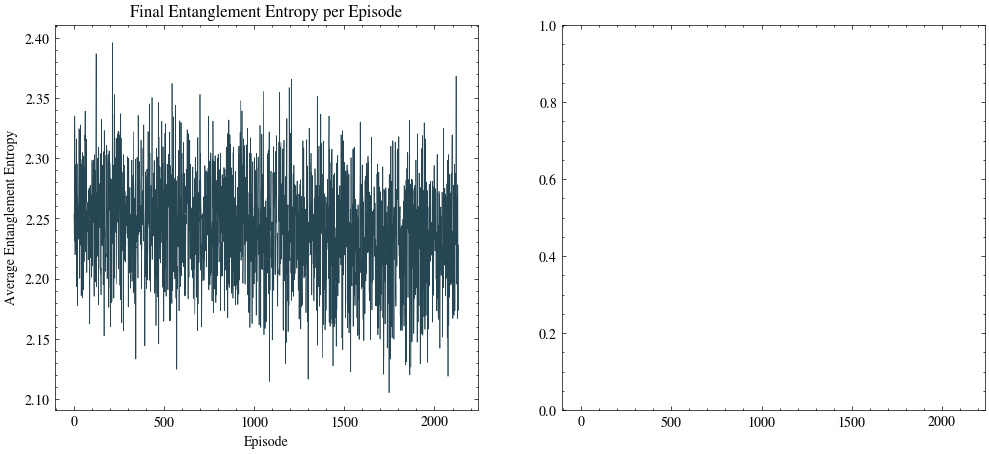

In [24]:
# 3. Plotting Results
fig, ax = Plotter.get_subplots(1, 2, figsize=(12, 5), sharex = True)
ax[0].plot(np.array(all_entropies) / env.Gamma, lw = 0.5)  # Normalize by Gamma to get average entropy per state
ax[0].set_title("Final Entanglement Entropy per Episode")
ax[0].set_xlabel("Episode")
ax[0].set_ylabel("Average Entanglement Entropy")
ax[0].axhline(y=entropy_values['average'], color='r', linestyle='--', label='Initial Avg Entropy')
ax[0].axhline(y=entropy_values['average_mixed'], color='g', linestyle='--', label='Initial Avg Mixed Entropy')

entropies_final = env.current_entropies
logger.info(f"Final entropies: {entropies_final}", color='blue', lvl=1)
logger.info(f"Submanifold mapping: {env.org_states_info['submanifold_mp']}", color='blue', lvl=1)
for i, e in enumerate(entropies_final):
    logger.info(f"Original state {i}: Entropy = {entropy_values['original'][i]:.3f}, Mixed state {i}: Entropy = {entropy_values['mixed'][i]:.3f}", color='blue', lvl=2)
    ax[0].axhline(y=e, color = 'blue', linestyle=':', alpha=0.5, label=f'$\\Gamma_{i} = {e:.3f}$')
ax[0].legend(frameon=True, loc='upper right')
ax[0].set_yscale('log')  # Use logarithmic scale for better visibility of entropies

ax[1].plot(np.array(all_rewards) - np.min(all_rewards), lw = 0.5)
ax[1].set_title("Approximate Episode Rewards")
ax[1].set_xlabel("Episode")
ax[1].set_ylabel("Reward")
ax[1].set_yscale('log')  # Use logarithmic scale for better visibility of rewards
fig.tight_layout()